# Часть 1. Приоритизация гипотез.

### Получение данных и их первичная обработка

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(rc={'figure.figsize':(10, 8)})

import scipy.stats as stats
from scipy import stats as st

import math

import numpy as np

pd.options.display.max_colwidth = 150

In [2]:
hypothesis = pd.read_csv('/datasets/hypothesis.csv')
orders = pd.read_csv('/datasets/orders.csv')
visitors = pd.read_csv('/datasets/visitors.csv')

Первым делом вы должны взгялнуть на данные и проверить их качество.

In [9]:
display(hypothesis.head())
hypothesis.info()

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [8]:
display(orders.head())

orders.info()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [10]:
display(visitors.head())
visitors.info()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


На первый взгляд мы видим только одну проблему - тип данных. В столбцах, где явно указана дата стоит иной тип. Преобразуем его.

In [27]:
orders['date'] = pd.to_datetime(orders['date'])
visitors['date'] = pd.to_datetime(visitors['date'])

Также изменим названия некоторых столбцов для удобства.

In [28]:
orders.rename(columns={'transactionId':'transactionid', 'visitorId':'visitorid'}, inplace=True)

Далее отчистим данные от дубликатов, если они имеются.

In [12]:
orders = orders.drop_duplicates()
orders

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
...,...,...,...,...,...
1192,2662137336,3733762160,2019-08-14,6490,B
1193,2203539145,370388673,2019-08-14,3190,A
1194,1807773912,573423106,2019-08-14,10550,A
1195,1947021204,1614305549,2019-08-14,100,A


In [13]:
visitors = visitors.drop_duplicates()
visitors

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
...,...,...,...
57,2019-08-27,B,720
58,2019-08-28,B,654
59,2019-08-29,B,531
60,2019-08-30,B,490


Теперь нам нужно определить период проведения теста. Как нам это сделать? Определим максимальную и минимальную дату.

In [15]:
print(orders['date'].min())
print(orders['date'].max())

2019-08-01 00:00:00
2019-08-31 00:00:00


Период равен месяцу. Далле нам нужно определить количество участников в группах, а точнее убедитсься, что оно корректно подобрано и сопостовимо между собой.

In [16]:
print(orders[orders['group']=='A']['visitorId'].nunique())
orders[orders['group']=='B']['visitorId'].nunique()

503


586

### Применение фреймворка ICE для приоритизации гипотез. Сортировка их по убыванию приоритета

In [17]:
hypothesis['ICE'] = round(hypothesis['Impact'] * hypothesis['Confidence'] / hypothesis['Efforts'], 2)

hypothesis.sort_values('ICE', ascending=False).head()

,Hypothesis,Reach,Impact,Confidence,Efforts,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00


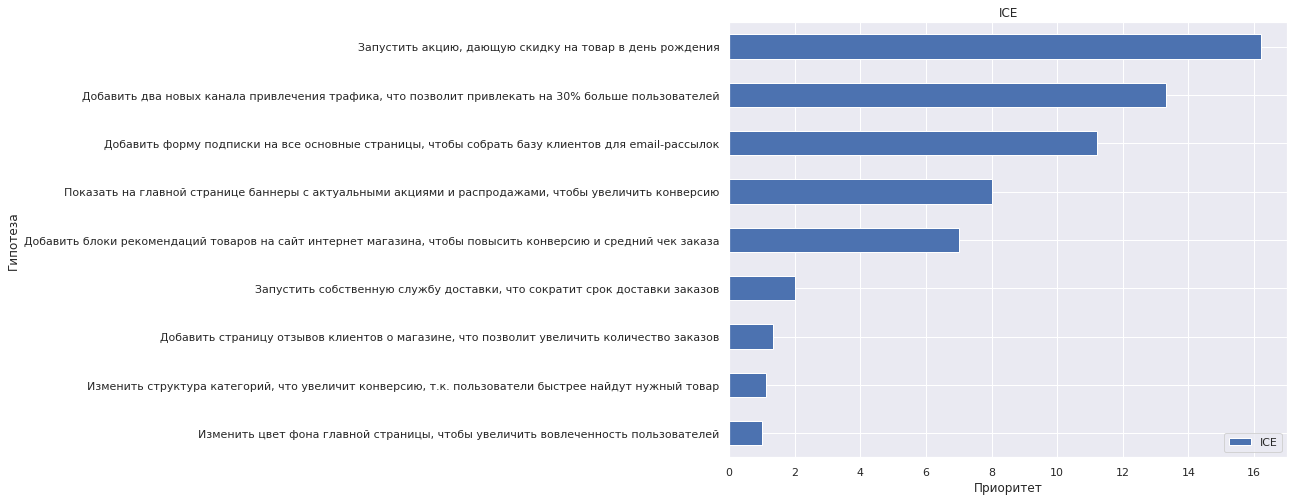

In [20]:
tg = hypothesis[['Hypothesis', 'ICE']].set_index('Hypothesis').sort_values('ICE', ascending=True).plot(kind='barh')
tg.set_xlabel('Приоритет')
tg.set_ylabel('Гипотеза')
tg.set_title('ICE')
plt.show()

### Применение фреймворка RICE для приоритизации гипотез. Сортировка их по убыванию приоритета

In [21]:
hypothesis['RICE'] = hypothesis['Reach'] * hypothesis['Impact'] * hypothesis['Confidence'] / hypothesis['Efforts']
hypothesis.sort_values('RICE', ascending=False).head()

,Hypothesis,Reach,Impact,Confidence,Efforts,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20,16.2


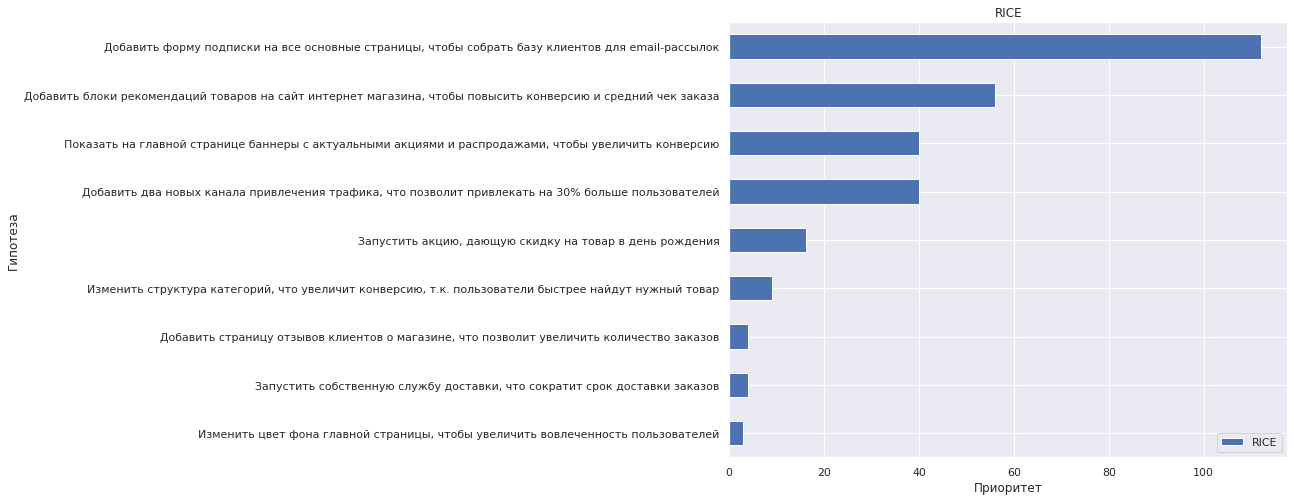

In [22]:
ax = hypothesis[['Hypothesis', 'RICE']].set_index('Hypothesis').sort_values('RICE', ascending=True).plot(kind='barh')
ax.set_xlabel('Приоритет')
ax.set_ylabel('Гипотеза')
ax.set_title('RICE')
plt.show()

### Описание изменений и их причин

Изменения значительные. Акция к дню рождения, стоявшая на первом месте в расчёте по фреймворку ICE, опустилась на 5 место по фреймворку RICE. Другие варианты не так значительно, но тем не менее изменили свои позиции в рейтинге.

Объяснить это можно тем, что формула для RICE учитывает охват (Reach). В акции к дню рождения охват минимальный, хотя и эффективный. В то время как форма подписки на все основные страницы, блоки рекомендаций, баннеры на шлавной странице и новые каналы привлечения трафика за счёт большего охвата в итоге дают гораздо больший эффект.

Вывод здесь достаточно однозначный - при оценке гипотез мы должны ориентироваться и обращать внимание на охват, он наиболее обширно позволяет нам захватить пользователей, а это нам нуджно и важно.

# Часть 2. Анализ A/B-теста

Подготовим данные для анализа. Сгруппируем данные по датам и группам А/В. Также сразу посчитаем кумулятивные суммы клиентов и покупок.

In [23]:
display(orders.head())
visitors.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [29]:
orders_grouped = (orders.groupby(['date','group'], as_index=False)
                        .agg({'transactionid':'nunique','visitorid':'nunique','revenue':'sum'}))\
                        .rename(columns={'transactionid':'orders','visitorid':'buyers'})
orders_grouped['group_copy'] = orders_grouped['group']
orders_grouped = orders_grouped.set_index(['date','group'])
orders_cumsum = orders_grouped.sort_values(['date','group']).groupby('group_copy').cumsum().reset_index()

In [30]:
display(orders_grouped)
orders_cumsum

orders  buyers  revenue group_copy
date       group                                    
2019-08-01 A          24      20   148579          A
           B          21      20   101217          B
2019-08-02 A          20      19    93822          A
           B          24      23   165531          B
2019-08-03 A          24      24   112473          A
...                  ...     ...      ...        ...
2019-08-29 B          20      20   231130          B
2019-08-30 A          11      10    86460          A
           B          24      24   215233          B
2019-08-31 A          12      12    61833          A
           B          20      20   133129          B

[62 rows x 4 columns]

,date,group,orders,buyers,revenue
0,2019-08-01,A,24,20,148579
1,2019-08-01,B,21,20,101217
2,2019-08-02,A,44,39,242401
3,2019-08-02,B,45,43,266748
4,2019-08-03,A,68,63,354874
...,...,...,...,...,...
57,2019-08-29,B,596,584,5559398
58,2019-08-30,A,545,531,4022970
59,2019-08-30,B,620,608,5774631
60,2019-08-31,A,557,543,4084803


Посчитаем сумму визитов по дням в каждой группе

In [32]:
visitors_cumsum = visitors.groupby(['date','group'], as_index=False).agg({'visitors':'sum'}).sort_values(['date','group'])
visitors_cumsum['group_copy'] = visitors_cumsum['group']
visitors_cumsum = visitors_cumsum.set_index(['date','group']).groupby('group_copy').cumsum().reset_index() 

In [35]:
visitors_cumsum

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-01,B,713
2,2019-08-02,A,1338
3,2019-08-02,B,1294
4,2019-08-03,A,1845
...,...,...,...
57,2019-08-29,B,17708
58,2019-08-30,A,18037
59,2019-08-30,B,18198
60,2019-08-31,A,18736


In [36]:
cummulative = orders_cumsum.join(visitors_cumsum[['visitors']])
cummulative['average_check'] = cummulative['revenue'] / cummulative['orders']
cummulative['conversion'] = cummulative['orders'] / cummulative['visitors']
cummulative.head()

,date,group,orders,buyers,revenue,visitors,average_check,conversion
0,2019-08-01,A,24,20,148579,719,6190.791667,0.033380
1,2019-08-01,B,21,20,101217,713,4819.857143,0.029453
2,2019-08-02,A,44,39,242401,1338,5509.113636,0.032885
3,2019-08-02,B,45,43,266748,1294,5927.733333,0.034776
4,2019-08-03,A,68,63,354874,1845,5218.735294,0.036856


Теперь нам нужно построить график кумулятивной выручки по группам. На его основе мы сделаем выводы и предположения.

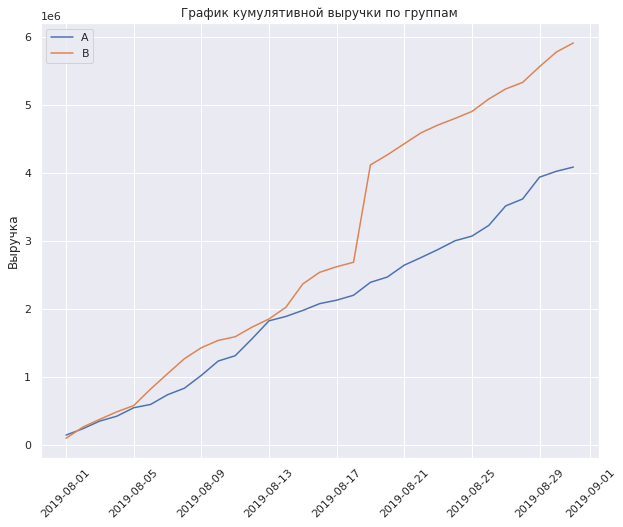

In [37]:
cummulativeA = cummulative[cummulative['group']=='A'][['date', 'revenue']]
cummulativeB = cummulative[cummulative['group']=='B'][['date', 'revenue']]
plt.plot(cummulativeA.iloc[:,0].to_frame(), cummulativeA.iloc[:,1].to_frame(), label='A' )
plt.plot(cummulativeB.iloc[:,0].to_frame(), cummulativeB.iloc[:,1].to_frame(), label='B')
plt.title('График кумулятивной выручки по группам')
plt.ylabel("Выручка")
plt.xticks(rotation=45)
plt.legend()
plt.show()

Видим резкий скачок графика В в районе 19 августа 2019. Возможно в этот день была очень крупная покупка, потому что в другие периоды график растёт примерно линейно.

Теперь нам нужно построить график кумулятивного среднего чека по группам. На его основе мы сделаем выводы и предположения.

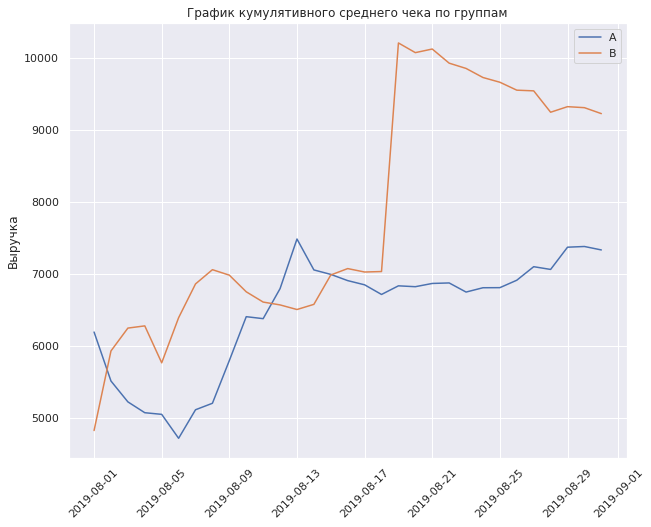

In [38]:
cummulativeA = cummulative[cummulative['group']=='A'][['date', 'average_check']]
cummulativeB = cummulative[cummulative['group']=='B'][['date', 'average_check']]
plt.plot(cummulativeA.iloc[:,0].to_frame(), cummulativeA.iloc[:,1].to_frame(), label='A' )
plt.plot(cummulativeB.iloc[:,0].to_frame(), cummulativeB.iloc[:,1].to_frame(), label='B')
plt.title('График кумулятивного среднего чека по группам')
plt.ylabel("Выручка")
plt.xticks(rotation=45)
plt.legend()
plt.show()


Повторяет предыдущий график. Снова скачок 19 августа на графике В, потом плавное снижение среднего, что означает возвращение к среднему диапазону стоимости заказов.

Постройте график относительного изменения кумулятивного среднего чека группы B к группе A. Сделайте выводы и предположения.

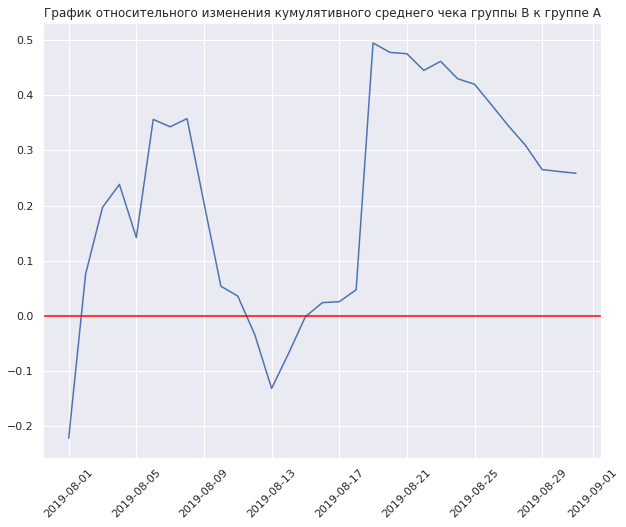

In [39]:
temp = (cummulativeA[['date', 'average_check']].merge(cummulativeB[['date', 'average_check']], 
                                            left_on='date', right_on='date', how='left', suffixes=['_A', '_B']))
plt.plot(temp['date'], temp['average_check_B'] / temp['average_check_A']-1)
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.axhline(y=0, color='red', linestyle='-')
plt.xticks(rotation=45)
plt.show()


Среднее значение В сначала было меньше А, потом заметно поднялось и опускалост ниже только 1 раз. На 19 августа тот самый скачок В опять имеет место быть на графике.

Постройте график кумулятивной конверсии по группам. Сделайте выводы и предположения.

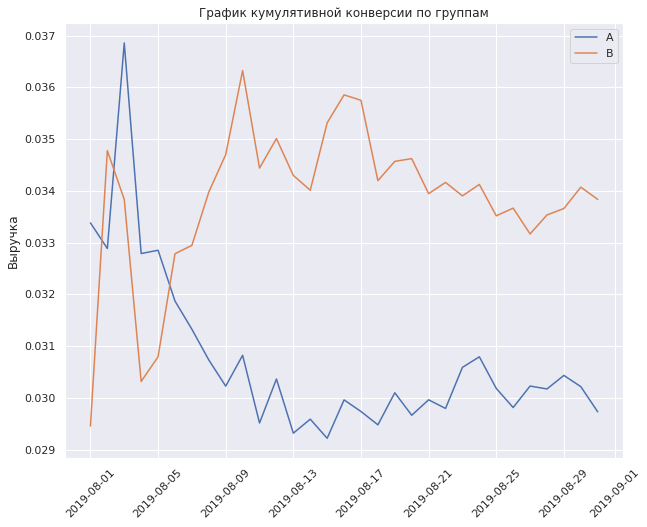

In [41]:
cummulativeA = cummulative[cummulative['group']=='A'][['date', 'conversion']]
cummulativeB = cummulative[cummulative['group']=='B'][['date', 'conversion']]
plt.plot(cummulativeA.iloc[:,0].to_frame(), cummulativeA.iloc[:,1].to_frame(), label='A' )
plt.plot(cummulativeB.iloc[:,0].to_frame(), cummulativeB.iloc[:,1].to_frame(), label='B')
plt.title('График кумулятивной конверсии по группам')
plt.ylabel("Выручка")
plt.xticks(rotation=45)
plt.legend()
plt.show()

В начале периода наблюдений конверсия почти одинаковая, но данных мало для каких-то выводов. В дальнейшем конверсия в группе В стабильно выше группы А.

Постройте график относительного изменения кумулятивной конверсии группы B к группе A. Сделайте выводы и предположения.

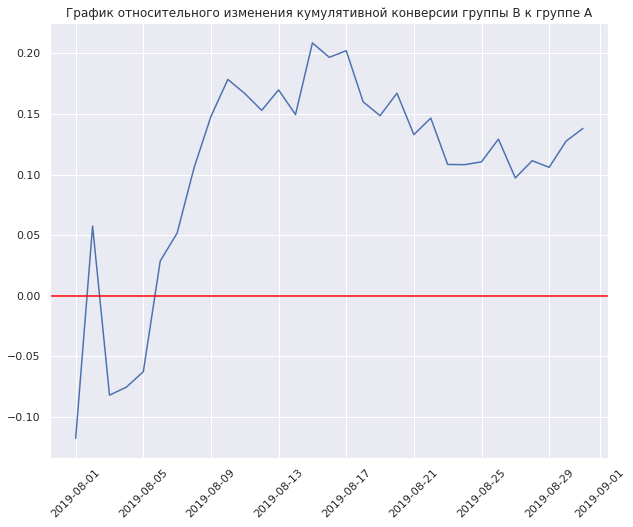

In [42]:
temp = (cummulativeA[['date', 'conversion']].merge(cummulativeB[['date', 'conversion']], 
                                            left_on='date', right_on='date', how='left', suffixes=['_A', '_B']))
plt.plot(temp['date'], temp['conversion_B'] / temp['conversion_A']-1)
plt.title('График относительного изменения кумулятивной конверсии группы B к группе A')
plt.axhline(y=0, color='red', linestyle='-')
plt.xticks(rotation=45)
plt.show()


В начале периода наблюдения из-за локальных колебаний в отдельные дни нельзя делать точные выводы о наших метриках. Но в дальнейшем на большем объёме данных ситуация стабилизируется и можно уверенно говорить, что кумулятивная конверсия в группе В стабильно больше, чем в А.

Постройте точечный график количества заказов по пользователям. Сделайте выводы и предположения.

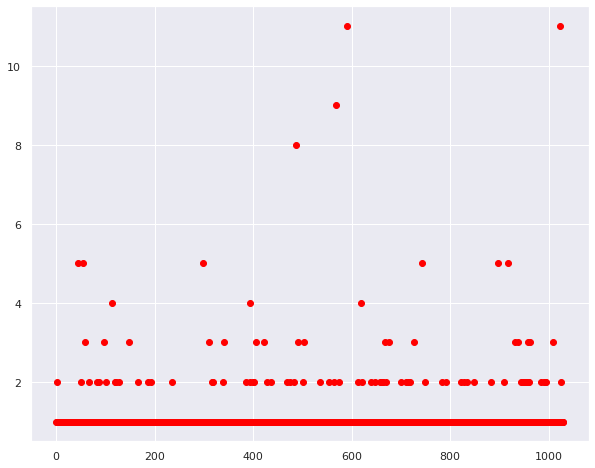

In [43]:
orders_per_user = orders.groupby('visitorid', as_index=False).agg({'transactionid':'nunique'})\
                         .rename(columns={'transactionid':'orders'})
x_values = pd.Series(range(0,len(orders_per_user['orders'])))
plt.scatter(x_values, orders_per_user['orders'], color='red')
plt.show()


Абсолютное большинство покупателей делают заказ 1 раз. Но есть и те, кому этого мало.

Посчитайте 95-й и 99-й перцентили количества заказов на пользователя. Выберите границу для определения аномальных пользователей.

In [45]:
print('95 перцентиль: %.2f' % (np.percentile(orders_per_user['orders'], [95])))
print('99 перцентиль: %.2f' % (np.percentile(orders_per_user['orders'], [99])))

95 перцентиль: 2.00
99 перцентиль: 4.00


In [48]:
print(orders_per_user['orders'].max())
print(np.ptp(orders_per_user['orders'], axis=0))


11
10


In [47]:
outlaws_1p = orders_per_user[orders_per_user['orders'] >= 4]['visitorid'].to_list()
outlaws_1p

[199603092,
 237748145,
 457167155,
 1230306981,
 1614305549,
 2038680547,
 2378935119,
 2458001652,
 2587333274,
 3062433592,
 3717692402,
 3803269165,
 4256040402]

В качестве границы аномалий взято значение 4 - пенсентиль 99

Всё, что выходит за рамки 99% - аномально. Таких пользователей-шопоголоков всего 10 человек. Немного на общем фоне.

Постройте точечный график стоимостей заказов. Сделайте выводы и предположения.

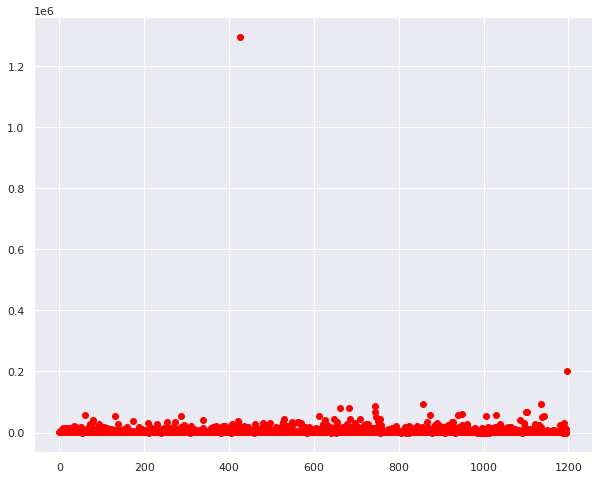

In [49]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'], color='red')
plt.show()

Визуально видны два выброса. Таие уникальные заказы слишом влияют на среднее. Скорее всего самый дорогой заказ (более миллиона) и дал нам скачок в первых графиках.

Посчитайте 95-й и 99-й перцентили стоимости заказов. Выберите границу для определения аномальных заказов.

In [50]:
print('95 перцентиль: %.2f' % (np.percentile(orders['revenue'], [95])))
print('99 перцентиль: %.2f' % (np.percentile(orders['revenue'], [99])))

95 перцентиль: 28000.00
99 перцентиль: 58233.20


In [51]:
print(orders['revenue'].max())
np.ptp(orders['revenue'], axis=0)

1294500


1294450

In [52]:
outlaws_2p = orders_per_user[orders['revenue'] >= 1294450]['visitorid'].to_list()
outlaws_2p

/tmp/ipykernel_48/1382730407.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  outlaws_2p = orders_per_user[orders['revenue'] >= 1294450]['visitorid'].to_list()


[1744796792]

Видим, что у нас есть один аномальный покупатель. Поэтому берём такое значение, чтобы именно этот один пользователь пропал из наших данных.

Посчитайте статистическую значимость различий в конверсии между группами по «сырым» данным. Сделайте выводы и предположения.

In [53]:
conversion = (orders.groupby('group').agg({'transactionid':'count'}).rename(columns={'transactionid':'orders'}))\
                                     .join((visitors.groupby('group').agg({'visitors':'sum'}))).reset_index()
conversion['conversion'] = conversion['orders'] / conversion['visitors']
conversion

,group,orders,visitors,conversion
0,A,557,18736,0.029729
1,B,640,18916,0.033834


Мы анализируем две ограниченные выборки данных, а не генеральные совокупности, из которых эти данные взяты. Значит нам надо оценить нормальность взятых выборок. Для этого посчитаем разницу между пропорциями, наблюдаемыми на выборках. Это делается с помощью Z-критерия для разности двух долей.

H0: Конверсия в группе A РАВНА конверсии в группе B

H1: Конверсия в группе A НЕ РАВНА конверсии в группе B

In [2]:
alpha=0.05
purchases = np.array(conversion['orders'])
leads = np.array(conversion['visitors'])
p1 = purchases[0] / leads[0]
p2 = purchases[1] / leads[1]
combined = (purchases[0] + purchases[1]) / (leads[0] + leads[1])
difference = p1-p2
z_value = difference / math.sqrt(combined * (1 - combined) * (1 / leads[0] + 1 / leads[1]))
distr = st.norm(0,1)
p_value = (1 - distr.cdf(abs(z_value))) * 2
print('p-значение: ', p_value)
if (p_value < alpha):
    print("Отвергаем нулевую гипотезу, конверсии не равны")
else:
    print("Не получилось отвергнуть нулевую гипотезу, конверсии равны")

NameError: name 'np' is not defined

Делаем вывод, что конверсии различны.

In [55]:
conversion_diff = (conversion['conversion'][1]/conversion['conversion'][0] - 1) * 100
conversion_diff

13.807884655320146

Конверсия в группе В превосходит конверсию в группе А на 13,8%. Многие маркетологи о таком росте могут только мечтать.

Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. Сделайте выводы и предположения.

В сырых данных есть существенные выбросы, которые влияют на среднее значение, поэтому параметрическими методами пользоваться не стоит. Воспользуемся непараметрическим критерием Манна-Уитни.

H0: Средний чек A НЕ ОТЛИЧАЕТСЯ от среднего чека группы B

H1: Средний чек A ОТЛИЧАЕТСЯ от среднего чека группы B

In [56]:
alpha = 0.05
results = st.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])
pvalue = results.pvalue
print('p-значение: ', pvalue)
if (pvalue < alpha):
    print("Отвергаем H0: разница статистически значима")
else:
    print("Не получилось отвергнуть H0: вывод о различии сделать нельзя")

p-значение:  0.7292909855432458
Не получилось отвергнуть H0: вывод о различии сделать нельзя


In [58]:
print('Группа А:', orders[orders['group']=='A']['revenue'].mean())
print('Группа В:', orders[orders['group']=='B']['revenue'].mean())

Группа А: 7333.578096947936
Группа В: 9230.875


Простое сравнение средних чеков по группам в данном случае ни о чём не говорит в плане статистической значимости. Видимо наш шопоголик-миллионер попал в группу В и подпортил нам статистику средних величин.

Посчитайте статистическую значимость различий в конверсии между группами по «очищенным» данным. Сделайте выводы и предположения.

In [60]:
orders_temp = orders[~orders['visitorid'].isin(outlaws_1p)]
conversion_clear = (orders_temp.groupby('group').agg({'transactionid':'count'}).rename(columns={'transactionid':'orders'}))\
                                                .join((visitors.groupby('group').agg({'visitors':'sum'}))).reset_index()

Аналогично "сырым" данным воспользуемся Z-критерием для разности двух долей.

H0: Конверсия в группе A РАВНА конверсии в группе B

H1: Конверсия в группе A НЕ РАВНА конверсии в группе B

In [1]:
alpha=0.05
purchases = np.array(conversion_clear['orders'])
leads = np.array(conversion_clear['visitors'])
p1 = purchases[0] / leads[0]
p2 = purchases[1] / leads[1]
combined = (purchases[0] + purchases[1]) / (leads[0] + leads[1])
difference = p1-p2
z_value = difference / math.sqrt(combined * (1 - combined) * (1 / leads[0] + 1 / leads[1]))
distr = st.norm(0,1)
p_value = (1 - distr.cdf(abs(z_value))) * 2
print('p-значение: ', p_value)
if (p_value < alpha):
    print("Отвергаем нулевую гипотезу, конверсии не равны")
else:
    print("Не получилось отвергнуть нулевую гипотезу, конверсии равны")

NameError: name 'np' is not defined

А вот по очищенным данным уже можно достаточно точно сказать, что конверсия в группе В превосходит конверсию в А.

Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. Сделайте выводы и предположения.

In [62]:
orders_clear = orders.query('revenue <= 58233')

Повторим использование критерия Манна-Уитни теперь для "очищенных" данных.

H0: Средний чек A НЕ ОТЛИЧАЕТСЯ от среднего чека группы B

H1: Средний чек A ОТЛИЧАЕТСЯ от среднего чека группы B

In [63]:
alpha = 0.05
results = st.mannwhitneyu(orders_clear[orders_clear['group']=='A']['revenue'], orders_clear[orders_clear['group']=='B']['revenue'])
pvalue = results.pvalue
print('p-значение: ', pvalue)
if (pvalue < alpha):
    print("Отвергаем H0: разница статистически значима")
else:
    print("Не получилось отвергнуть H0: вывод о различии сделать нельзя")

p-значение:  0.6208626966847455
Не получилось отвергнуть H0: вывод о различии сделать нельзя


In [64]:
print('Группа А:',orders_clear[orders_clear['group']=='A']['revenue'].mean())
print('Группа В:',orders_clear[orders_clear['group']=='B']['revenue'].mean())

Группа А: 6470.587272727273
Группа В: 6592.692913385827


Да, чек изменился, но это статистически несущественно.

# Принятие решения и его объяснение.

Исходные данные: 
- Продолжительность проведенного теста - 1 месяц с 1 августа по 31 августа 2019 года. 
- Пользователи были разделены на группы А (503 пользователя) и В (586 пользователей).

Итог экспермента:
- Конверсия в группе В статистически значимо выросла, хотя средний чек остался примерно таким же. Значит изменения есть. Скорее всего, искать первопричину надо именно в типе товара, которым торгует наш магазин (этих данных у нас нет). Это позволило бы нам делать более качественный вывод о том, как влияет возраст, время года и остальные факторы.


Из-за нехватки более точных данных и, чтобы убедиться в высокой внешней валидности теста, я приняла бы решение продолжить тест, так как наш эксперимент продолжался всего месяц, чего не достаточно для точного вывода об отсуствтвии влияния внешних факторов на него.